In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from propagation import laser
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
plt.style.use('notes')

path = '/mnt/md0/Data/rariniello/Experimental/Test_Optic_1/'
lam = 0.796
# All length units are in um

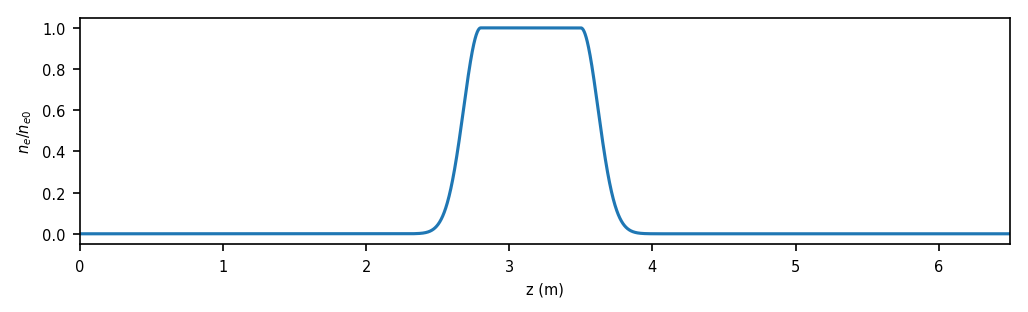

In [2]:
# Plasma density of 2.5e16 
# Deccelerating gradient for the drive beam is -13.03 GeV/m
# Accelerating gradient for the witness beam is 15.19 GeV/m
# We want to make a plasma at least 210um wide and 70cm long
# Helium gas to minimize the effect of beam ionization
length = 70e4
width = 210

# The optic can be anywhere from 2.9m to 3.2m from the beginning of the second chamber

# Create the grid for the setup
Nz = 2**16
Z = 100e6 # Needs to be very large to provide resolution in the frequency domain
z, dz = np.linspace(0, Z, Nz, retstep=True)
frac_l = np.zeros(Nz, dtype='double')

# On axis plasma density profile is given by
# Uniform accelerating plasma
z0 = 2.8e6 # start of the uniform plasma
sel_u = np.logical_and(z > z0, z < z0+length)
frac_l[sel_u] = 1.0

# Entrance ramp
l_ent = 50e4 # length of the entrance ramp
s_ent = 12e4
sel_ent = np.logical_and(z >= z0-l_ent, z <= z0)
ramp_ent = np.exp(-(z-z0)**2/(2*s_ent**2))
frac_l[sel_ent] = ramp_ent[sel_ent]

#Exit ramp
l_ext = 50e4 # length of the entrance ramp
s_ext = 12e4
sel_ext = np.logical_and(z >= z0+length, z <= z0+length+l_ext)
ramp_ext = np.exp(-(z-z0-length)**2/(2*s_ext**2))
frac_l[sel_ext] = ramp_ext[sel_ext]

xlim = [0, 6.5]
#xlim = [2.4, 4]
#xlim = [3.25, 4]
#xlim = [2, 2.5]
plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, frac_l)
plt.xlabel(r'z (m)')
plt.ylabel(r'$n_e/n_{e0}$')
plt.xlim(xlim)
plt.show()

np.save(path+'plasma.npy', [z, frac_l])

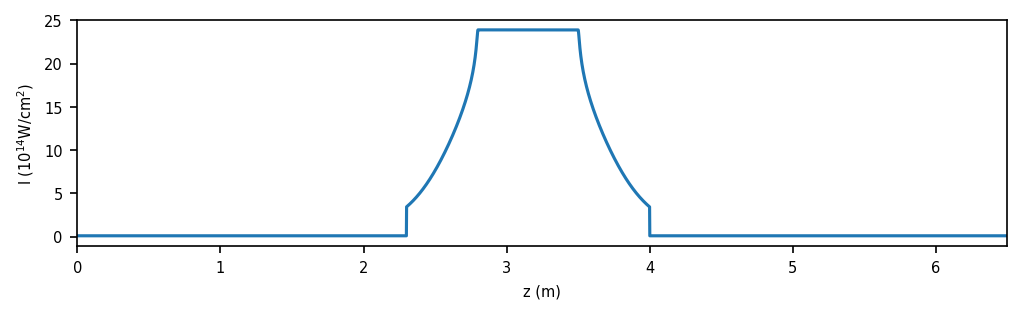

In [3]:
# Calculate the desired on axis intensity profile from the ionization fraction
# Assume a pulse with a Gaussian temporal shape
tau = 30 # RMS pulse length in fs
ion = {'atom' : ionization.He,
       'tau' : tau,
       'type' : 'gaussian'}
I_l = ionization.intensity_from_density(ion, 0.999*frac_l)

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_l)
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()

Plasma starts at 1.82m and ends at 4.48m


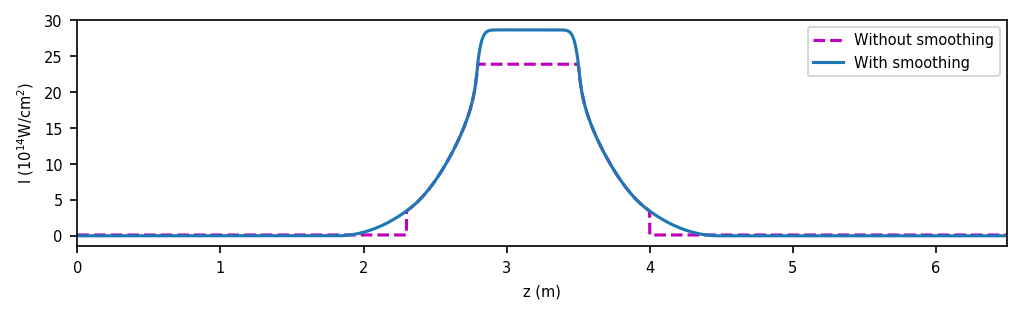

In [4]:
# The intensity profile needs to be smoothed to remove steps and hard corners

# Smooth the center section and increase the intensity
order = 8
Imax = np.amax(I_l)
z_u = z[sel_u]
zc = 0.5*(z_u[-1] + z_u[0])
w = (z_u[0] - zc)**(2*order)/0.6
I_la = np.copy(I_l)
I_new = 0.4*Imax*(np.exp(-(z_u - zc)**(2*order)/w)-0.5)
I_la[sel_u] += I_new

#Smooth the beginning of the entrance ramp with a parabola
I_ent = I_l[sel_ent]
gradI = (I_ent[1] - I_ent[0]) / dz
A = gradI**2 / (4*I_ent[0])
B = z[sel_ent][0] - 2*I_ent[0]/gradI
sel = np.logical_and(z >= B, z < z0-l_ent)
I_la[sel] = A*(z[sel]-B)**2
I_la[z < B] = 0.0
plasma_start = B

#Smooth the end of the exit ramp with a parabola
I_ext = I_l[sel_ext]
gradI = (I_ext[-1] - I_ext[-2]) / dz
A = gradI**2 / (4*I_ext[-1])
B = z[sel_ext][-1] - 2*I_ext[-1]/gradI
sel = np.logical_and(z <= B, z > z0+length+l_ext)
I_la[sel] = A*(z[sel]-B)**2
I_la[z > B] = 0.0
plasma_end = B

print('Plasma starts at %0.2fm and ends at %0.2fm' % (plasma_start/1e6, plasma_end/1e6))
plasma_size = [plasma_start, plasma_end]
np.save(path+'plasma_size.npy', plasma_size)

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_l, '--m')
plt.plot(z/1e6, I_la)
plt.legend(['Without smoothing', 'With smoothing'])
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()

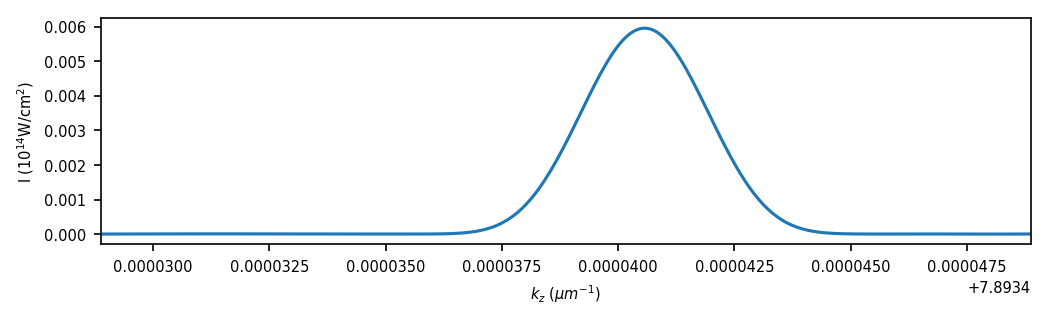

In [5]:
# Lets look at the spatial frequency componenets of the ramp
# The end of the plot is the maximum supported frequency
params = {
    'Nr' : 5000,
    'R' : 20e3,
    'w' : 210,
    'lam' : lam
}
r = np.linspace(0, params['R'], params['Nr'])
E = np.zeros(params['Nr'], dtype='complex128')
Ez = ionization.field_from_intensity(I_la)
k = 2*np.pi/lam
dz = z[1] - z[0]
# Shift frequencies
kr0 = 2.4048 / params['w']
kz0 = np.sqrt(k**2 - kr0**2)
kz = 2*np.pi * fftshift(fftfreq(Nz, dz)) + kz0
e = fftshift(fft(Ez)) / Nz

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(kz, ionization.intensity_from_field(e))
plt.xlabel(r'$k_z$ ($\mu m^{-1}$)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(k-2e-5, k)
plt.show()

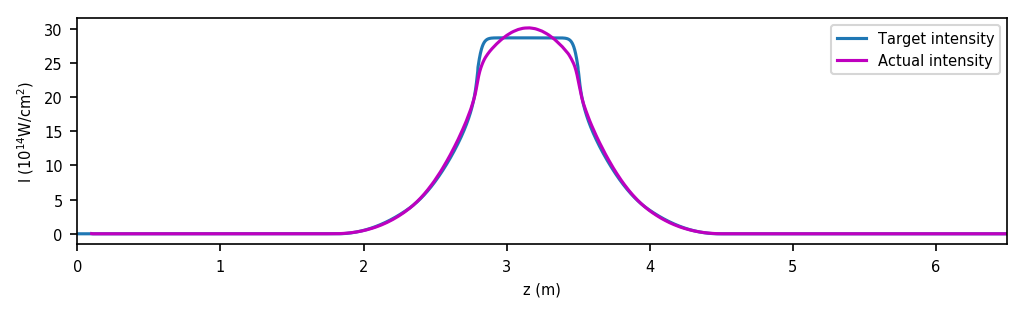

In [6]:
# Calculate the required intensity and phase profile after the beam shaping optics
r, E = bessel.bessel_expansion(params, z, I_la)
zFres = np.linspace(1e5, 8e6, 1000)
eFres = laser.fresnel_axis(E, r, zFres, lam)
IFres = ionization.intensity_from_field(eFres)

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_la)
plt.plot(zFres/1e6, IFres, 'm')
plt.legend(['Target intensity', 'Actual intensity'])
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()

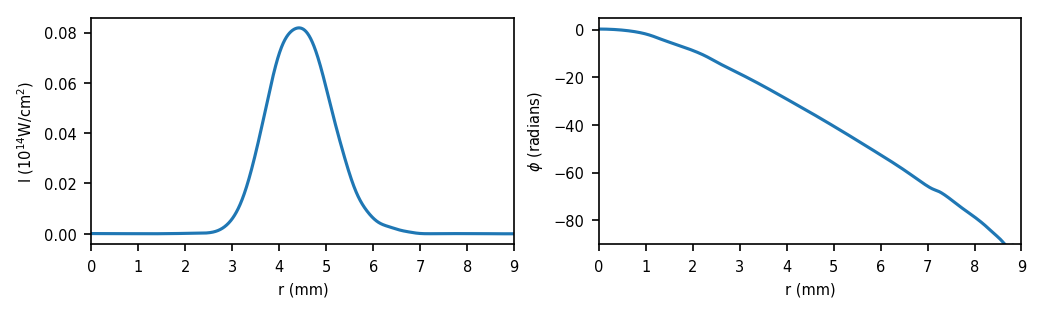

In [7]:
# Radial dependence of the phase and and intensity after the beam shaping optics
rlim = [0, 9]
plt.figure(figsize=(8, 2), dpi=150)
plt.subplot(121)
plt.plot(r/1e3, ionization.intensity_from_field(E))
plt.xlabel(r'r (mm)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(rlim)
plt.subplot(122)
plt.plot(r/1e3, np.unwrap(np.angle(E)))
plt.xlabel(r'r (mm)')
plt.ylabel(r'$\phi$ (radians)')
plt.xlim(rlim)
plt.ylim(-90, 5)
plt.show()

In [8]:
# Design the tandem lenses to create the beam from the output of the laser
# First, we have to define what the incoming laser beam looks like
# Super Gaussian profile with 30mm diameter, order and things determined by our laser
n = 8
w0 = 15e3
E0 = 2.3
Ei = E0 * np.exp(-(r/w0)**n)

# Call the first lens A and the second lens B first make sure the power is equal
Ii = ionization.intensity_from_field(Ei)
Io = ionization.intensity_from_field(E)
Pi = 2*np.pi*simps(r*Ii*1e-4, r*1e-4)*100
Po = 2*np.pi*simps(r*Io*1e-4, r*1e-4)*100
Ei *= np.sqrt(Po/Pi)
Ii = ionization.intensity_from_field(Ei)

# The first lens shapes the intensity on the second one
L = 30e4 # distance between the tandem optics
rA, phiA = ray.lens_design(Ii, r, Io, r, L)
phiA *= 2*np.pi/lam

# Create the first lens
Nx = 2**12
X = 40e3
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'LensA',
              'lam' : lam,
              'load' : False}

lensA = optic.Phase(lensParams)
phi = lensA.reconstruct_from_cyl(rA, phiA, lensA.x, lensA.y)
lensA.initialize_phase(phi)

# The phase difference between neighboring cells must be less than pi
dphi = np.sort(abs(phi[1:, int(Nx/2+1)]-phi[:-1, int(Nx/2+1)]))[-3]
print('Maximum phase change in one pixel %0.2f rad' % dphi)

# Create the initial beam to pass through the lens
beamParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam0_A_to_B',
              'threads' : 4,
              'cyl' : True,
              'load' : False}

beam0 = laserbeam.Laser(beamParams)
np.save(path+'initial_E.npy', Ei)
np.save(path+'initial_r.npy', r)
e = beam0.reconstruct_from_cyl(r, Ei, beam0.x, beam0.y)
beam0.initialize_field(e)
print('Peak power %0.2f' % (beam0.total_cyl_power(r, Ii)))

Maximum phase change in one pixel 2.37 rad
Peak power 3.95


In [9]:
# Propagate the initial beam through the lens and to the second lens
# The actual phase at the second lens is needed to determine the phase delay of the lens
interactions.beam_phase(beam0, lensA)
beam0.propagate(L, 1.0)

In [10]:
# The second lens (B) removes the phase from the first lens and adds an axicon like phase
r0 = -beam0.x[:int(beam0.Nx/2+1)]
e0 = beam0.e[:int(beam0.Nx/2+1), int(beam0.Ny/2+1)]
phi0 = np.unwrap(np.angle(e0))
phi0 = phi0 - phi0[-1]
phiB = np.unwrap(np.angle(E)) - beam0.reconstruct_from_cyl(r0, phi0, r, np.zeros(1))[:, 0]

# Create the second lens, the domain is smaller for this one
Nx = 2**11
X = 20e3
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'LensB',
              'lam' : lam,
              'load' : False}

lensB = optic.Phase(lensParams)
phi = lensB.reconstruct_from_cyl(r, phiB, lensB.x, lensB.y)
lensB.initialize_phase(phi)
dphi = np.sort(abs(phi[1:, int(Nx/2+1)]-phi[:-1, int(Nx/2+1)]))[-3]
print('Maximum phase change in one pixel %0.2f rad' % dphi)

Maximum phase change in one pixel 2.49 rad


In [11]:
# Create a new beam after the phase shaping optics
beamParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam1_PostOptic',
              'threads' : 4,
              'cyl' : True,
              'load' : False}

beam1 = laserbeam.Laser(beamParams)
e = beam1.reconstruct_from_cyl(r0, e0, beam1.x, beam1.y)
beam1.initialize_field(e)
interactions.beam_phase(beam1, lensB)

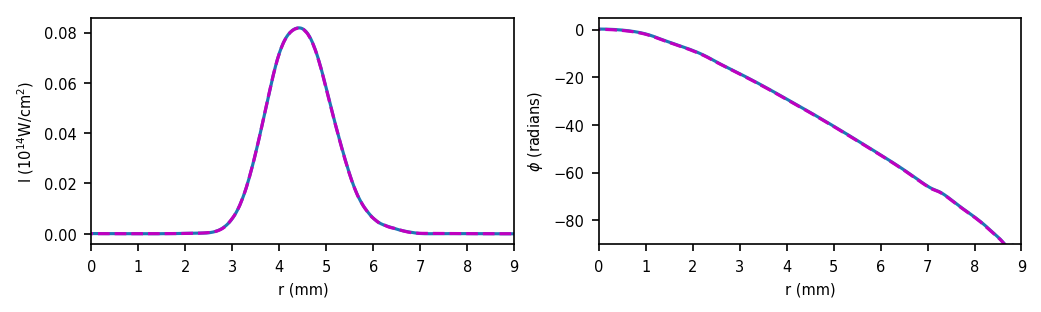

In [12]:
# Radial dependence of the phase and and intensity after the beam shaping optics
r1 = -beam1.x[:int(beam1.Nx/2+1)]
e1 = beam1.e[:int(beam1.Nx/2+1), int(beam1.Ny/2+1)]

rlim = [0, 9]
plt.figure(figsize=(8, 2), dpi=150)
plt.subplot(121)
plt.plot(r/1e3, ionization.intensity_from_field(E))
plt.plot(r1/1e3, ionization.intensity_from_field(e1), 'm--')
plt.xlabel(r'r (mm)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(rlim)
plt.subplot(122)
plt.plot(r/1e3, np.unwrap(np.angle(E)))
plt.plot(r1/1e3, np.unwrap(np.angle(e1))-np.unwrap(np.angle(e1))[-1], 'm--')
plt.xlabel(r'r (mm)')
plt.ylabel(r'$\phi$ (radians)')
plt.xlim(rlim)
plt.ylim(-90, 5)
plt.show()

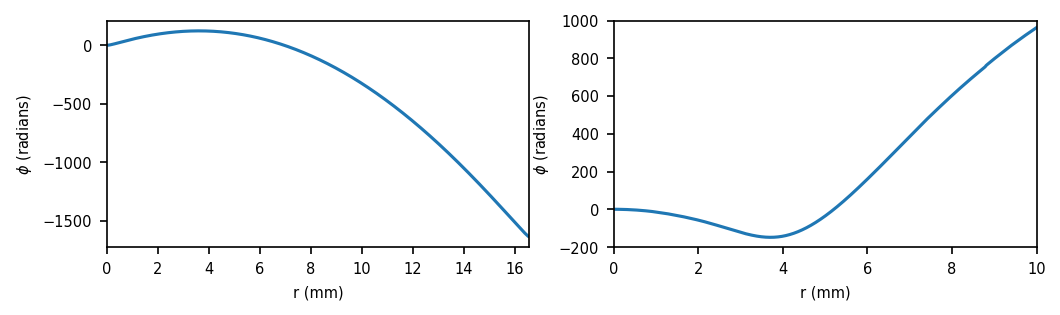

In [13]:
plt.figure(figsize=(8, 2), dpi=150)
plt.subplot(121)
plt.plot(rA/1e3, phiA)
plt.xlabel(r'r (mm)')
plt.ylabel(r'$\phi$ (radians)')
plt.xlim(0, np.amax(rA)/1e3)
plt.subplot(122)
plt.plot(r/1e3, phiB)
plt.xlabel(r'r (mm)')
plt.ylabel(r'$\phi$ (radians)')
plt.xlim(0, X/2e3)
plt.ylim(-200, 1000)
plt.show()